# Import

In [3]:
import sys
import os
import glob
import gc
import datetime

import pandas as pd
import numpy as np
from dotenv import load_dotenv
load_dotenv(verbose=False)
# viz
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

from utils.loguri import setup_logger, logging_resource
from utils.now import get_now


In [4]:
# 로그 디렉토리 및 파일 설정
LOG_DIR = os.getenv("PATH_LOG_VIRTUAL")
now = get_now()
setup_logger(LOG_DIR, now)
logging_resource()

2024-12-07 11:34:02.662 | INFO     | utils.loguri:logging_resource:86 - 4.9 | 6057.902 | 24037.179 | 52768.277 | 1031018.425 | 280.762 | 279.928


In [5]:
PATH_DATA = os.getenv("PATH_DATA_VIRTUAL")
PATH_RAW = os.path.join(PATH_DATA, "raw")

# 개요

관망구조 A에 대한 EDA

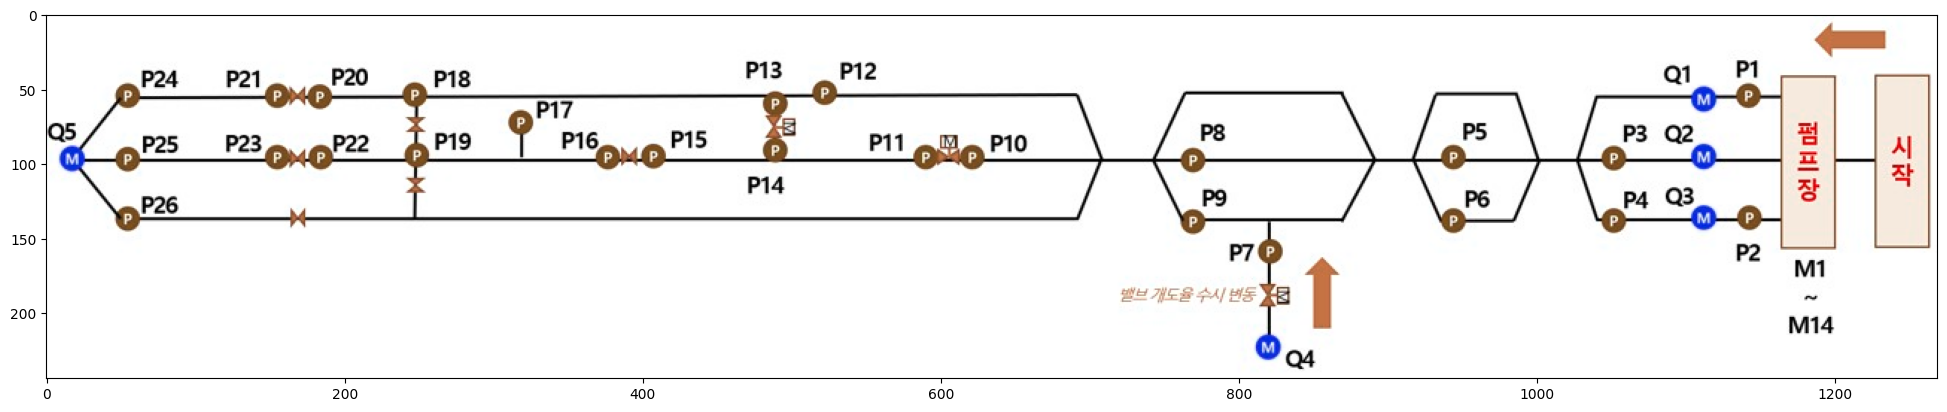

In [6]:
path_image = "meta_관망구조이미지/train/관망구조_A.jpg"
scale = 0.1

path_image = os.path.join(PATH_RAW, path_image)
im = cv2.imread(path_image)
plt.figure(figsize=(im.shape[0]*scale,im.shape[1]*scale))
plt.imshow(im)

"관망구조_A의 경우에는 물이 들어와서 중앙에서 합류하는 특이케이스인 관계로 화살표 방향을 표시하였으며, 화살표 방향이 없는 나머지 관망 B,C,D는 모두 물이 빠져나가는 구조입니다."
즉, 문의주신 관망구조_C의 경우에도 특이케이스가 아니므로 별다른 화살표 방향이 없으며, 모두 물이 빠져나가는 구조입니다.


In [7]:
path_data = "train/TRAIN_A.csv"
path_data = os.path.join(PATH_RAW, path_data)
df = pd.read_csv(path_data)

In [8]:
df.shape

(44101, 73)

In [9]:
df.columns

Index(['timestamp', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'P1', 'P2',
       'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13',
       'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23',
       'P24', 'P25', 'P26', 'anomaly', 'P1_flag', 'P2_flag', 'P3_flag',
       'P4_flag', 'P5_flag', 'P6_flag', 'P7_flag', 'P8_flag', 'P9_flag',
       'P10_flag', 'P11_flag', 'P12_flag', 'P13_flag', 'P14_flag', 'P15_flag',
       'P16_flag', 'P17_flag', 'P18_flag', 'P19_flag', 'P20_flag', 'P21_flag',
       'P22_flag', 'P23_flag', 'P24_flag', 'P25_flag', 'P26_flag'],
      dtype='object')

시간, Q 5개, M 14개, P 26개, P_flag 26개, 어노말리로 이루어짐

# Univariate Analysis

## 시간, 타겟

### timestamp

In [10]:
df['timestamp'].head(5)

0    24/05/27 00:00
1    24/05/27 00:01
2    24/05/27 00:02
3    24/05/27 00:03
4    24/05/27 00:04
Name: timestamp, dtype: object

일반적이지 않은 날짜 형태의 string이므로 데이터 처리 필요

In [11]:
df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x, "%y/%m/%d %H:%M"))

In [12]:
df.shape, df.set_index("timestamp").resample("1T").mean().shape, df['timestamp'].isna().sum()

/tmp/ipykernel_2387453/1318956027.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.shape, df.set_index("timestamp").resample("1T").mean().shape, df['timestamp'].isna().sum()


((44101, 73), (44101, 72), np.int64(0))

1분간격 연속 시간값으로 보입니다.

In [13]:
df['timestamp'].min(), df['timestamp'].max()

(Timestamp('2024-05-27 00:00:00'), Timestamp('2024-06-26 15:00:00'))

### 타겟 : anomaly, P_flag

- anomaly: 해당 시점에서의 정상(0), 이상(1) 여부
- P_flag: 해당 시점에서의 압력계의 정상(0), 이상(1) 여부

In [14]:
df["anomaly"].unique()

array([0, 1])

In [15]:
df["anomaly"].isna().sum()

np.int64(0)

In [16]:
df["anomaly"].value_counts()

anomaly
0    44071
1       30
Name: count, dtype: int64

결측 없이 이상치(1) 30개 존재

In [17]:
for flag in [x for x in df.columns if "flag" in x]:
    print(f"{flag}이상비율 : {df[flag].sum()/len(df[flag])}, {df[flag].sum()}/{len(df[flag])}")

P1_flag이상비율 : 0.0, 0/44101
P2_flag이상비율 : 0.0, 0/44101
P3_flag이상비율 : 0.0, 0/44101
P4_flag이상비율 : 0.0, 0/44101
P5_flag이상비율 : 0.0, 0/44101
P6_flag이상비율 : 0.0, 0/44101
P7_flag이상비율 : 0.0, 0/44101
P8_flag이상비율 : 0.0006802566835219156, 30/44101
P9_flag이상비율 : 0.0006802566835219156, 30/44101
P10_flag이상비율 : 0.0, 0/44101
P11_flag이상비율 : 0.0, 0/44101
P12_flag이상비율 : 0.0, 0/44101
P13_flag이상비율 : 0.0, 0/44101
P14_flag이상비율 : 0.0, 0/44101
P15_flag이상비율 : 0.0, 0/44101
P16_flag이상비율 : 0.0, 0/44101
P17_flag이상비율 : 0.0, 0/44101
P18_flag이상비율 : 0.0, 0/44101
P19_flag이상비율 : 0.0, 0/44101
P20_flag이상비율 : 0.0, 0/44101
P21_flag이상비율 : 0.0, 0/44101
P22_flag이상비율 : 0.0, 0/44101
P23_flag이상비율 : 0.0, 0/44101
P24_flag이상비율 : 0.0, 0/44101
P25_flag이상비율 : 0.0, 0/44101
P26_flag이상비율 : 0.0, 0/44101


전체 시간 441010분 중 30분 간 P8, P9에서 이상발생

In [18]:
df[df['P8_flag']==1]['P9_flag'].sum()

np.int64(30)

P8 이상발생시간 = P9이상발생시간

In [19]:
df[df['P8_flag']==1]['anomaly'].sum()

np.int64(30)

P8 이상발생시간 = anomaly 판단 시간

anomaly 판단 기준 : '누수가 발생한 위치를 특정할 수 있는, 직접적으로 관련이 있는 압력계' 

## features

### M(모터 가동)

In [20]:
df[[x for x in df.columns if "M" in x]].head(5)

,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M13,M14
0,0,0,0,1,0,1,1,1,0,0,1,0,0,1
1,0,0,0,1,0,1,1,1,0,0,1,0,0,1
2,0,0,0,1,0,1,1,1,0,0,1,0,0,1
3,0,0,0,1,0,1,1,1,0,0,1,0,0,1
4,0,0,0,1,0,1,1,1,0,0,1,0,0,1


In [21]:
def get_periods(l):
    res = list(map(str, l))
    res = ''.join(res)
    res = res.split("0")
    res = list(map(len, res))
    res = list(filter(lambda x: x, res))
    return res

for M in [x for x in df.columns if "M" in x]:
    periods = get_periods(df[M].tolist())
    oprate = sum(periods)/len(df)*100
    print(M, periods, f"{oprate}%")

M1 [] 0.0%
M2 [] 0.0%
M3 [] 0.0%
M4 [3796, 40304] 99.99773247772158%
M5 [428, 1, 6457, 3830] 24.298768735402827%
M6 [8741, 1313, 1574, 1156, 11764, 2770] 61.94417360150564%
M7 [147, 1601, 582, 358, 1, 280, 1081, 1269, 1093, 86, 783, 120, 370, 450, 993, 862, 2811, 635, 526, 64, 52, 75, 905, 1395, 231, 164, 867, 236, 331, 171, 1503, 977, 194, 657] 49.59071222874765%
M8 [554, 33400] 76.99145144101041%
M9 [16661, 8380, 13665] 87.76671730799755%
M10 [] 0.0%
M11 [13098, 30243] 98.27668306841116%
M12 [408, 138, 5484, 7702, 873, 838, 1881] 39.28255595111222%
M13 [] 0.0%
M14 [669, 90, 231, 370, 244, 76, 647, 58, 83, 616, 141, 642, 109, 371, 1062, 296, 240, 839, 1363, 2336, 281, 174, 1306, 1211, 2037, 1843, 169, 111, 158, 280, 549, 476] 43.25979002743702%


- 몇몇 모터는 가동을 안함
- 도중에 끊긴 경우도 존재
- 거의 항상 가동한 모터 M4
- 상관분석을 통해 압력계와 연관된 모터 분석필요

### P(압력계)

이상이 있는 P8,9와 항상 정상인 P5(이상이 발생한 압력계보다 앞부분에 위치) 먼저 비교

<Axes: >

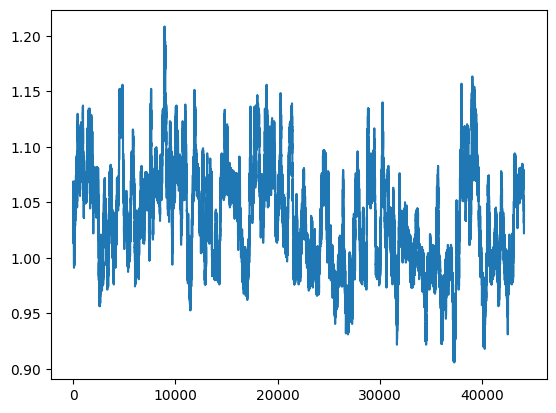

In [22]:
df['P5'].plot()

In [23]:
len(df)

44101

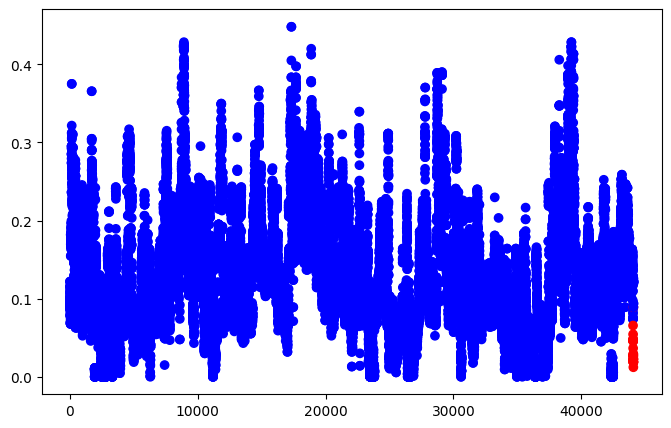

In [24]:
plt.figure(figsize=(8, 5))
ind = 0
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P8"][ind:],  # y축: float 컬럼
    c=df["P8_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

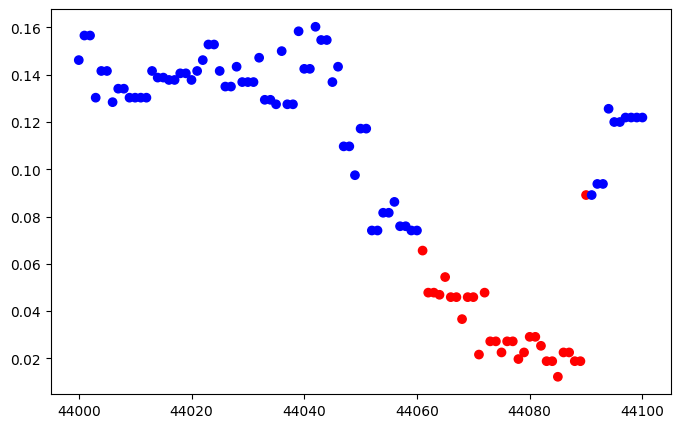

In [25]:
plt.figure(figsize=(8, 5))
ind = 44000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P8"][ind:],  # y축: float 컬럼
    c=df["P8_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

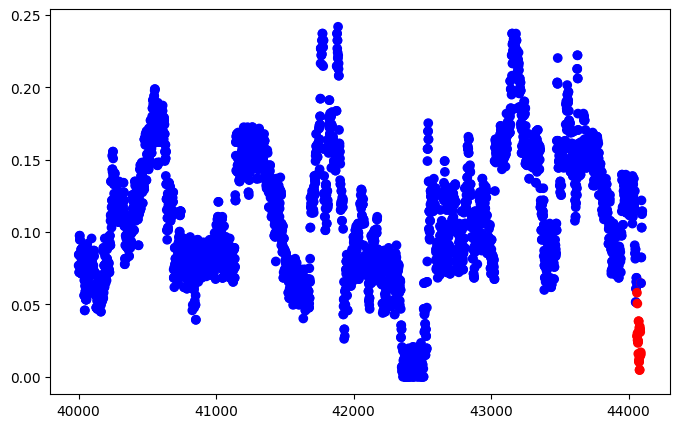

In [26]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P9"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

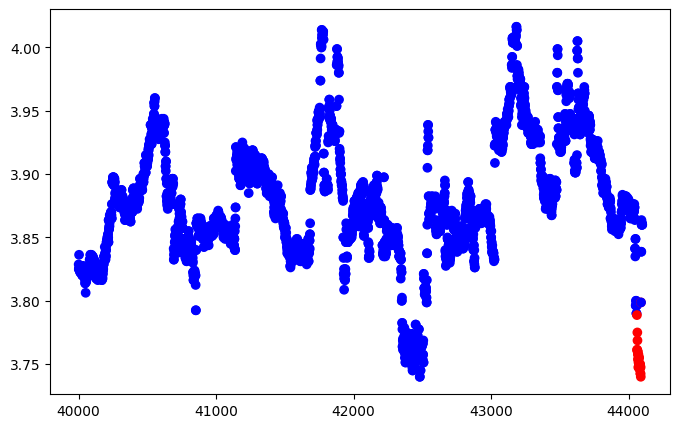

In [27]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P7"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

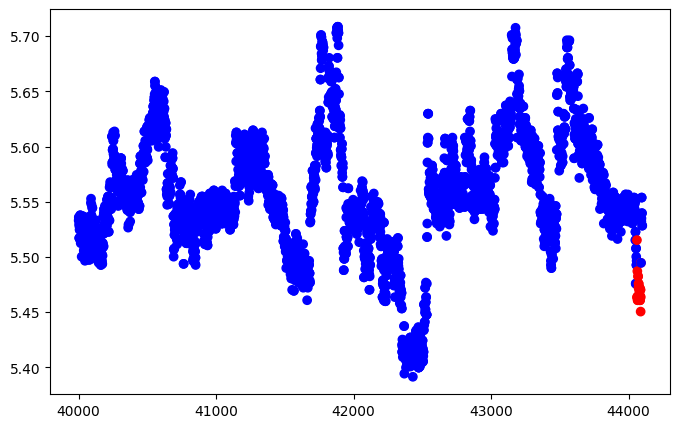

In [30]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P10"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

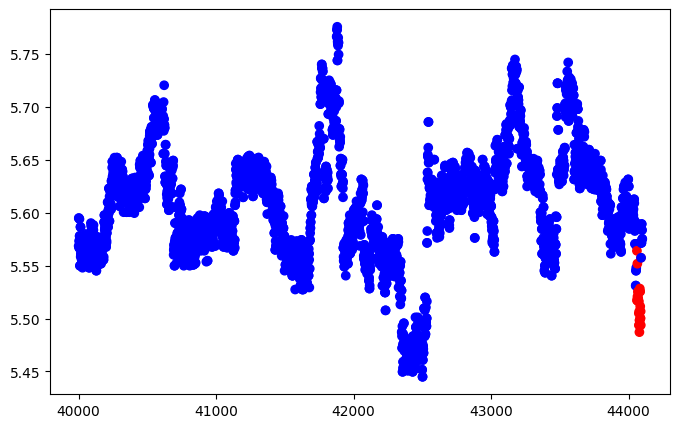

In [31]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P11"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

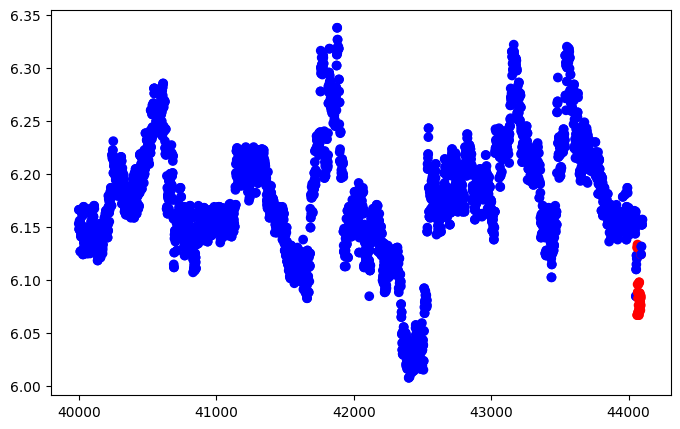

In [32]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P12"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

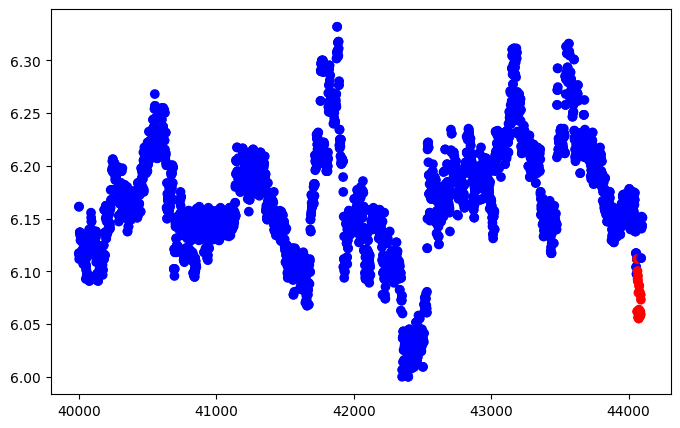

In [33]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P13"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

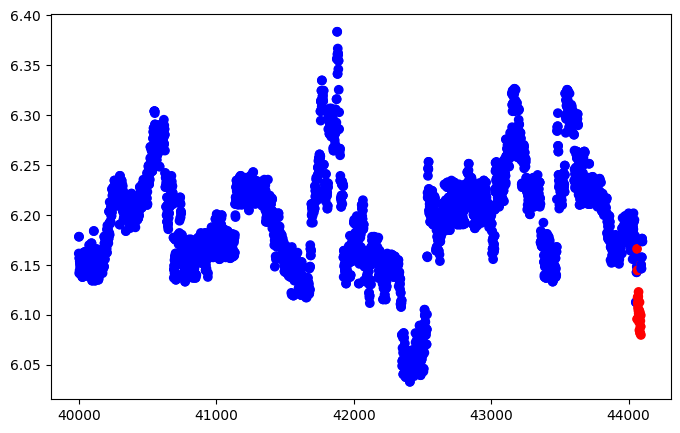

In [34]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P14"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

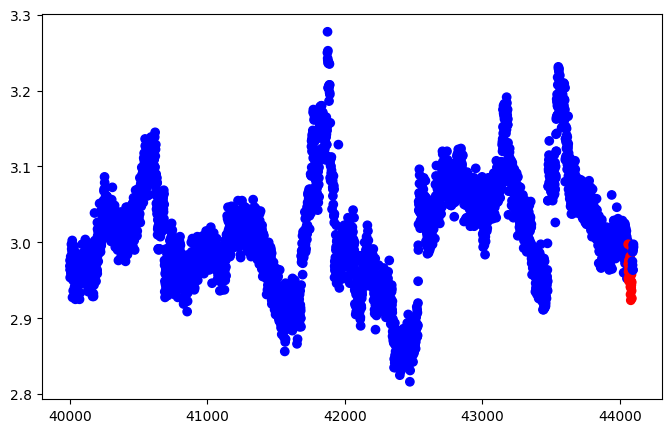

In [35]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P15"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

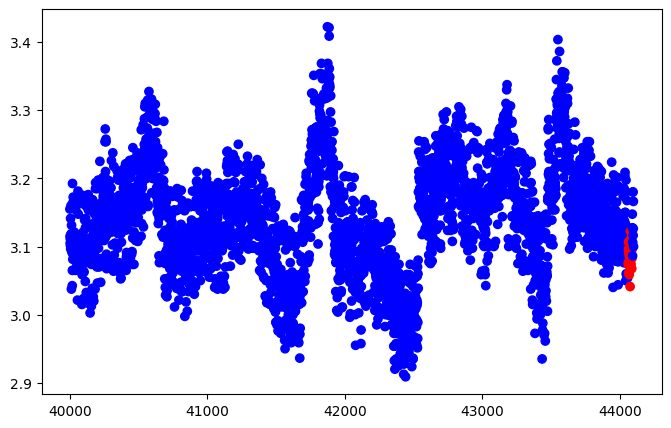

In [36]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P16"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

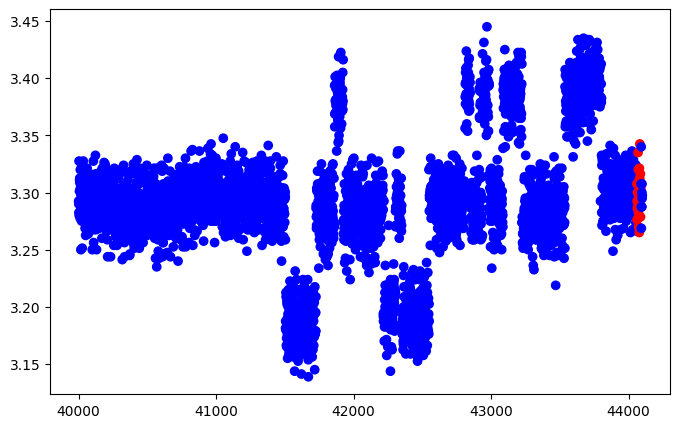

In [37]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P17"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

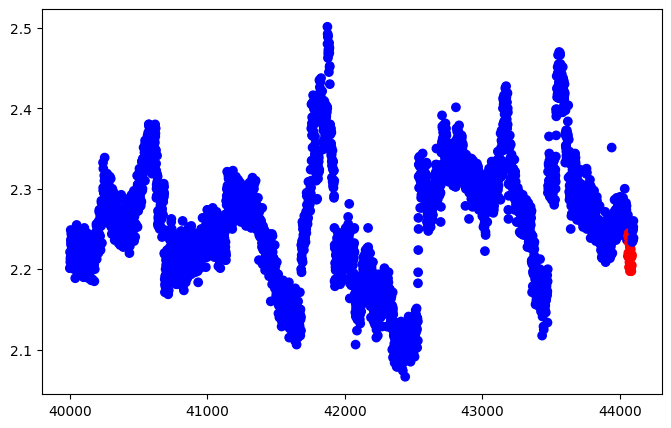

In [38]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P18"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

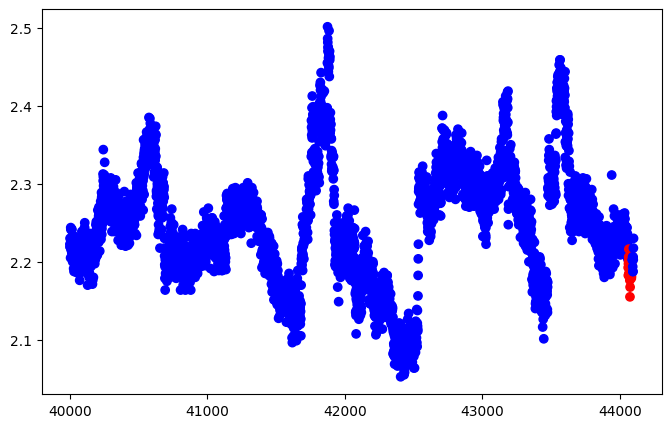

In [39]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P19"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

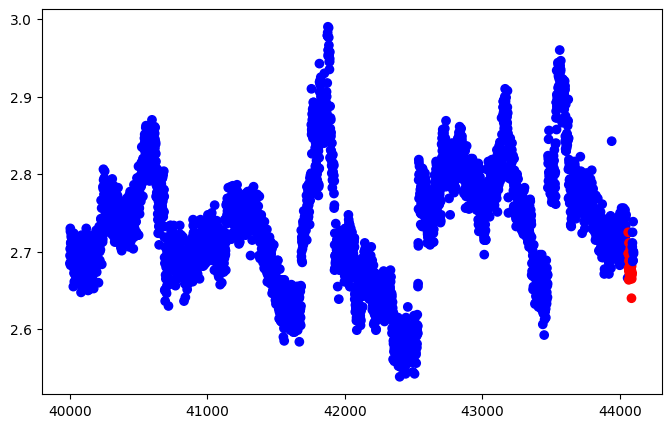

In [40]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P20"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

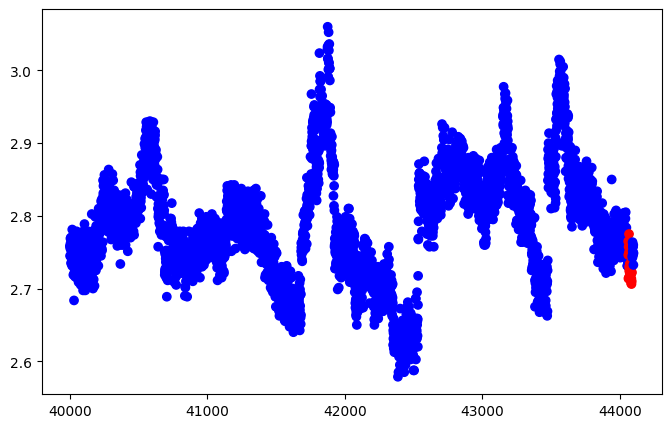

In [41]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P21"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

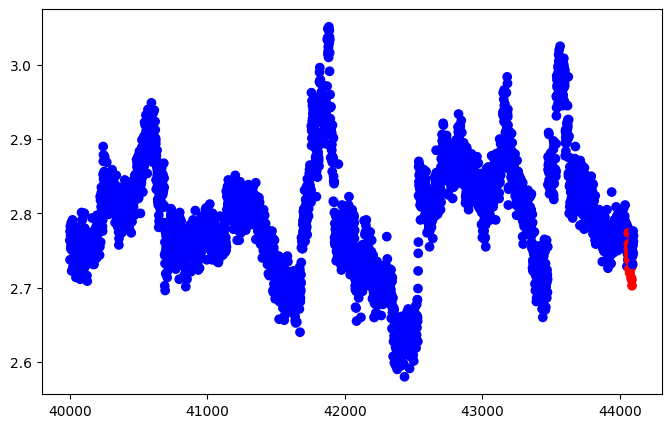

In [42]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P22"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

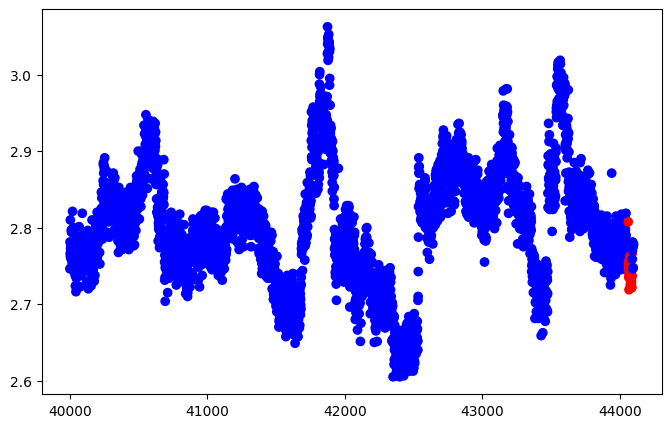

In [43]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P23"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

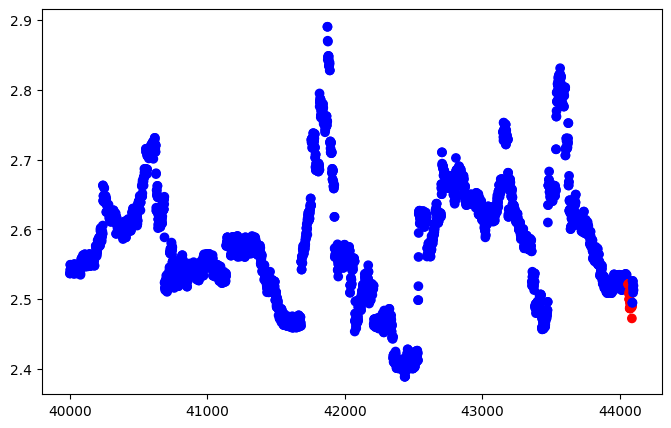

In [44]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P24"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

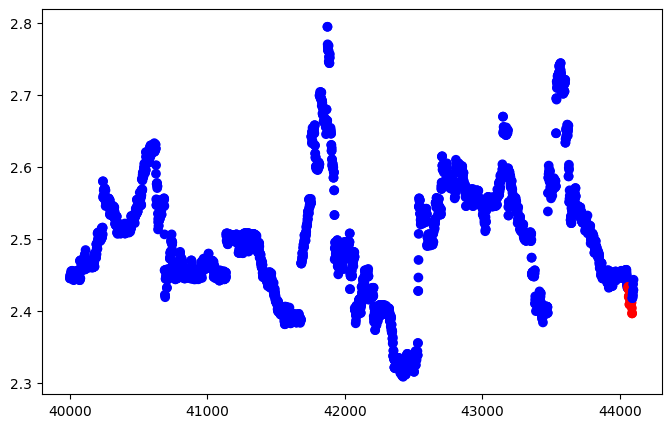

In [45]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P25"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

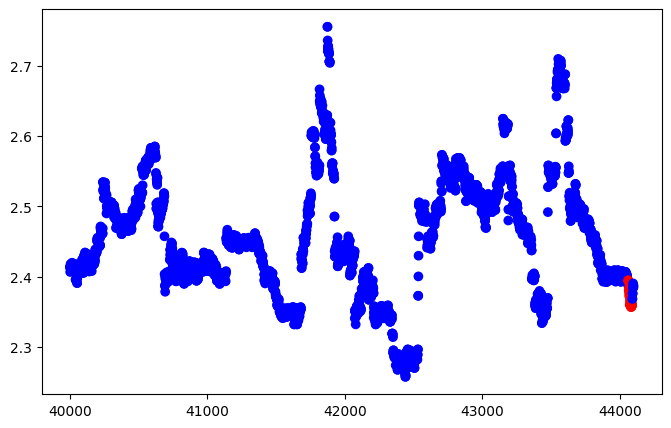

In [46]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P26"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

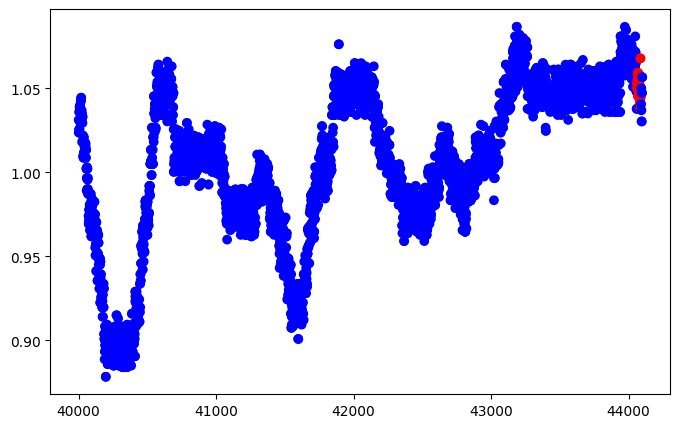

In [48]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P6"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

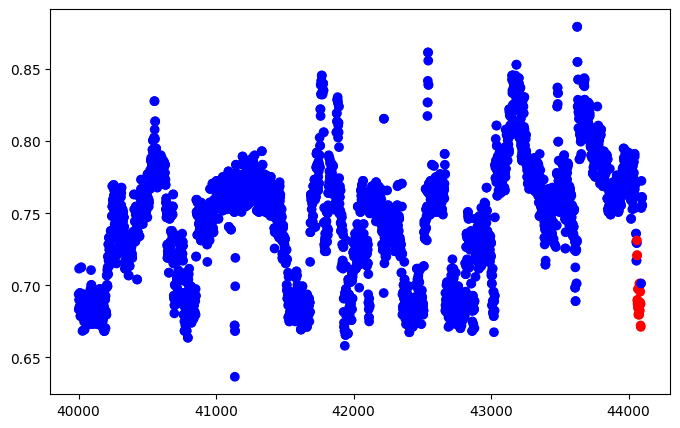

In [49]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P4"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

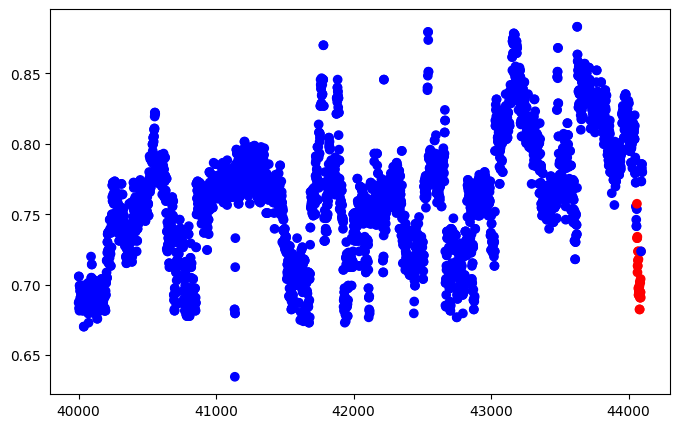

In [50]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P3"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

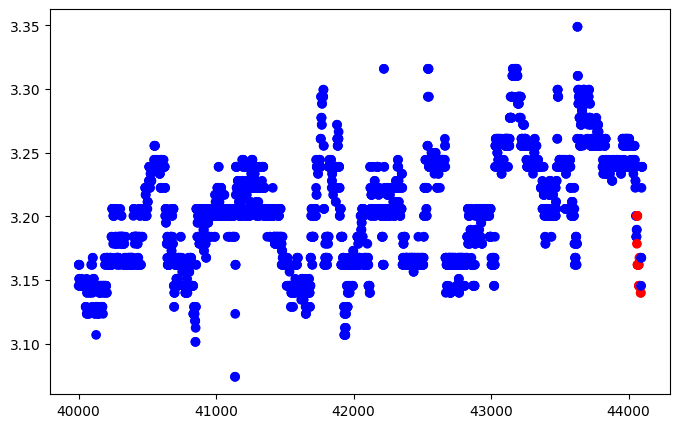

In [51]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P2"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

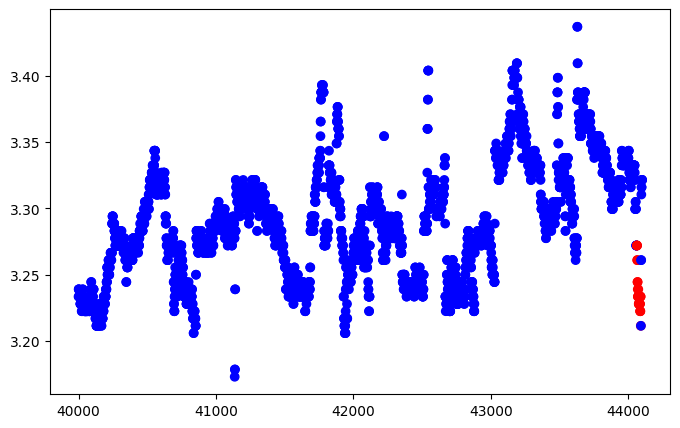

In [52]:
plt.figure(figsize=(8, 5))
ind = 40000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["P1"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

P만 보고는 알 수 없다... 연관분석, 상관분석 해보고 나중에 다시 생각하자

### Q(유량)

In [56]:
df[[x for x in df.columns if "Q" in x]].head()

,Q1,Q2,Q3,Q4,Q5
0,17880,37151.001,24834.001,6321,85828
1,17970,37069.001,25016.001,6367,85212
2,17280,37345.000,24462.000,6431,85655
3,17280,37345.000,24462.000,6431,85619
4,17920,37075.000,24896.001,6206,85619


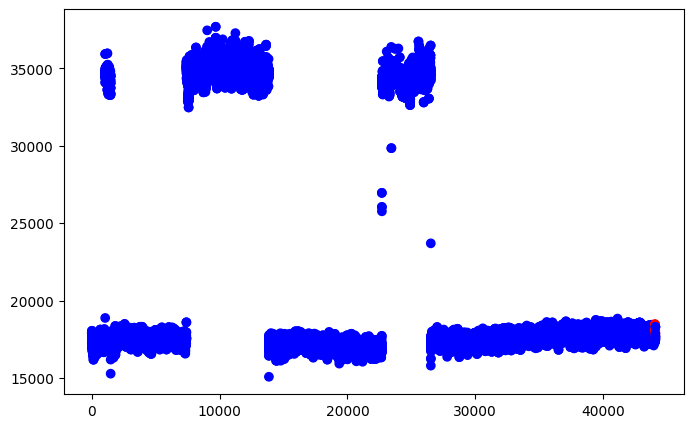

In [64]:
plt.figure(figsize=(8, 5))
ind = 0
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["Q1"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

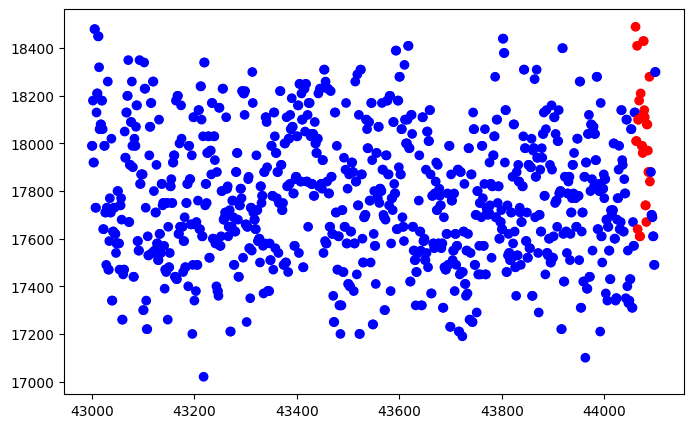

In [68]:
plt.figure(figsize=(8, 5))
ind = 43000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["Q1"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

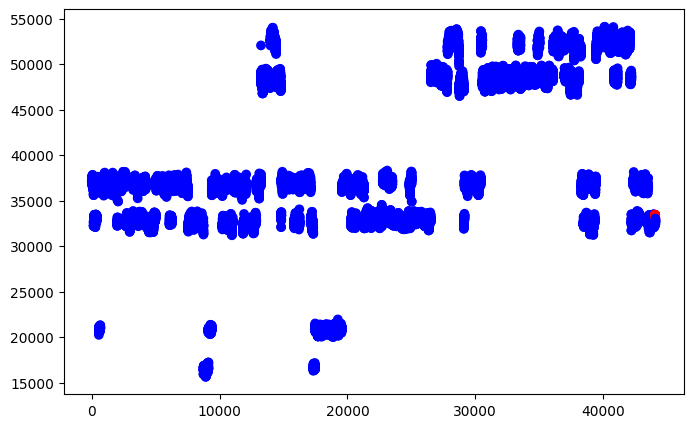

In [65]:
plt.figure(figsize=(8, 5))
ind = 0
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["Q2"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

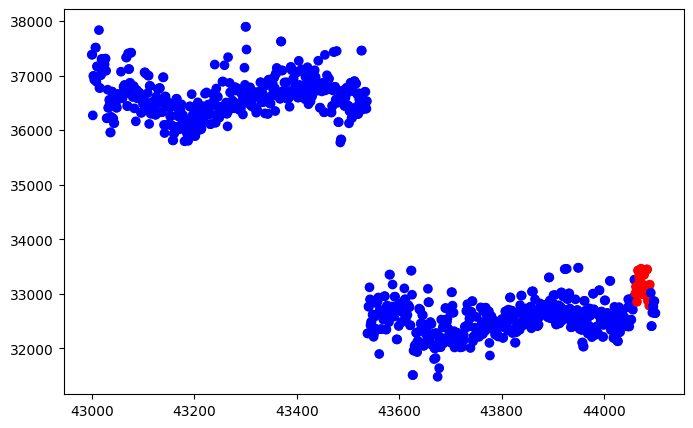

In [69]:
plt.figure(figsize=(8, 5))
ind = 43000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["Q2"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

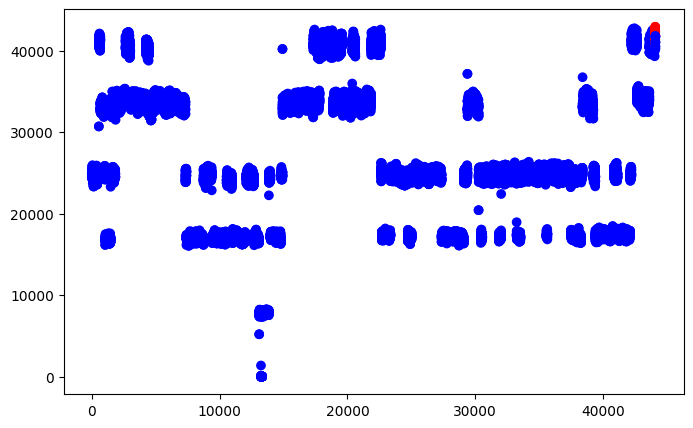

In [70]:
plt.figure(figsize=(8, 5))
ind = 0
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["Q3"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

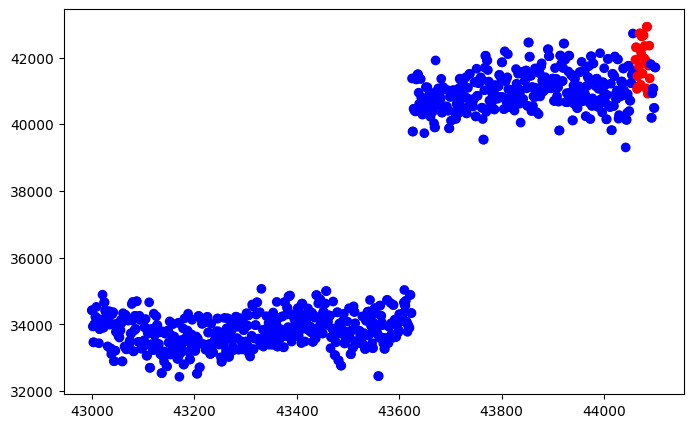

In [71]:
plt.figure(figsize=(8, 5))
ind = 43000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["Q3"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

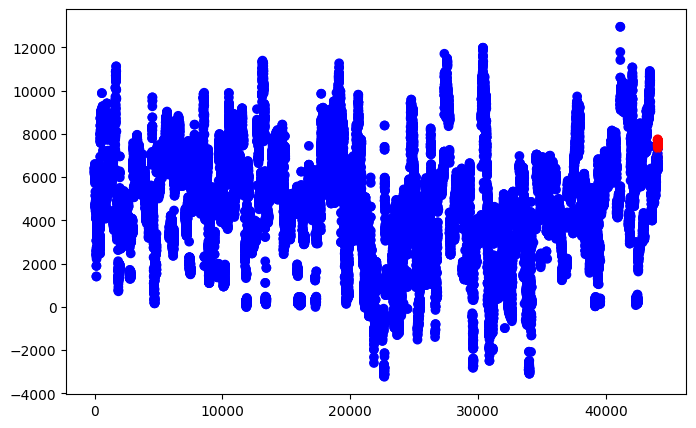

In [72]:
plt.figure(figsize=(8, 5))
ind = 0
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["Q4"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

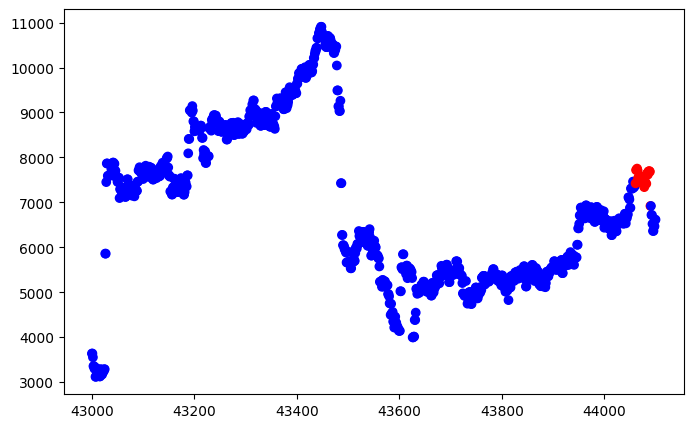

In [73]:
plt.figure(figsize=(8, 5))
ind = 43000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["Q4"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

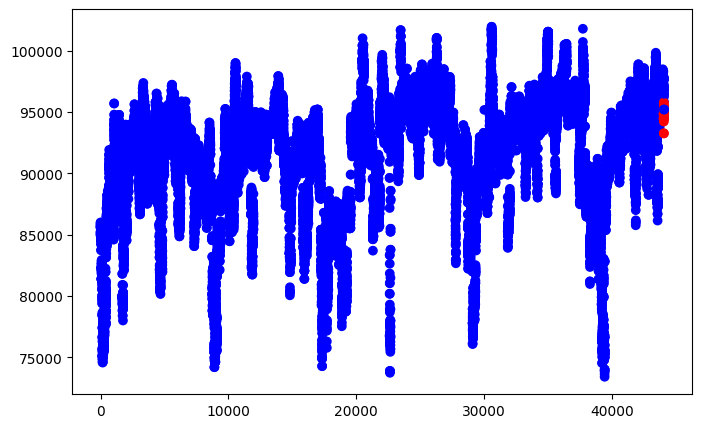

In [74]:
plt.figure(figsize=(8, 5))
ind = 0
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["Q5"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

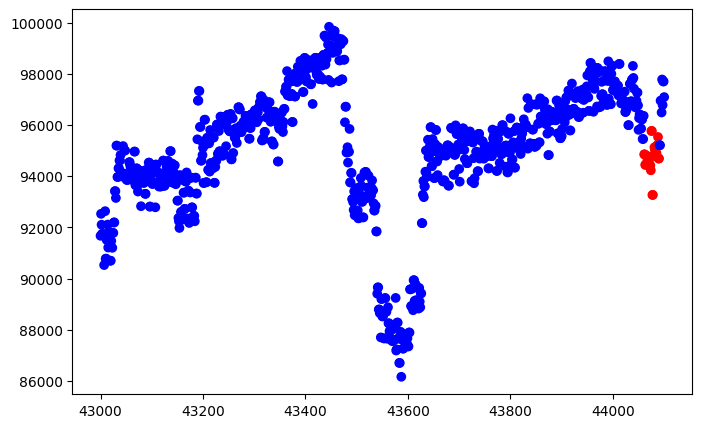

In [75]:
plt.figure(figsize=(8, 5))
ind = 43000
plt.scatter(
    df[ind:].index,  # x축: 데이터의 인덱스
    df["Q5"][ind:],  # y축: float 컬럼
    c=df["P9_flag"][ind:].map({1: "red", 0: "blue"}),  # 색상: bool 컬럼에 따라 결정
    label=["1", "0"]
)
plt.show()

Q는 확실히 관망구조 뒷단으로 갈 수 록 값이 작아지며 high freq 값이 커진다

# 결론

떠오르는 요구사항

- 관망구조와 상관 없이 general한 모델을 만들어야한다. 
    - 시스템에 상관없는 모델이 만들어져야한다.
    - 따라서 연관성, 상관성을 고려한 network를 구축해야한다.
    - 또한 압력계노드를 포함한 이 시스템(아마 그래프)에는 방향이 있으며, 정보전달에 시간딜레이가있다.
        - 타겟을 지정할 때 이상 탐지 후 누수가 발생된 것으로 보이는 첫 번째 압력계를 선택해야 함. 이를 네트워크에서 구현하거나 anomaly를 따로 감지 후 그 정보를 후처리하여 이상정보 전달
        - 연관관계를 파악하기위한 데이터학습 시 시간딜레이 고려
- 입력이 달라질 수 있고 출력의 길이 또한 입력길이에 따라 달라진다. 이 것은 sequential하기 때문임이 아니므로 시스템마다 새 모델을 만들 수 있도록 설계해야한다.
- 매우 imbalance한 데이터로 관련 잡기술을 적용해봐야한다.
- 지금은 타겟이 주어졌지만, 이상치여부를 사람이 짚어주는것 또한 업무기때문에 사람의 개입을 최소화하기위해 타겟이 주어지지 않았을때도 작동해야함

요구사항에 따른 의견

1. General한 모델
    - 요구사항: 관망구조에 의존하지 않는 일반화된 모델을 설계.
    - 해결책:
        - Graph Attention Network (GAT):
            노드 간 중요도와 방향성을 동적으로 학습.
            다양한 관망 구조와 상관없는 일반화된 설계 가능.
        - Graph Autoencoder (GAE):
            엣지 정보를 추론하고 고정된 상태에서 이상 탐지 수행.
2. 딜레이와 방향성 반영
    - 요구사항: 관망 시스템의 방향성과 정보 전달 딜레이를 반영.
    - 해결책:
        - GAT:
            - 방향성을 모델링하며, 딜레이를 feature로 추가하여 학습 가능.
        - Dynamic Graph Learning (DGL):
            - 딜레이를 시간 축으로 자연스럽게 반영하고, 동적 변화 학습.
        - 후처리 모듈:
            탐지된 이상에서 첫 번째 누수 압력계 식별.
3. 시스템 별 모델 재구축 가능성
    - 요구사항: 시스템마다 입력 및 출력이 달라지며, 새 모델 학습 가능해야 함.
    - 해결책:
        - Modular 설계:
            - 기본 네트워크 구조를 공유하되, 시스템별 특성을 반영할 수 있도록 설계.
        - GAE:
            - 데이터에 따라 엣지 구조를 새로 학습 가능.
4. Imbalanced 데이터 처리
    - 요구사항: 이상 데이터가 매우 불균형하므로 학습 성능 보완 필요.
    - 해결책:
        - Focal Loss:
            - 학습 시 이상 데이터에 더 높은 가중치를 부여.
        - Oversampling:
            - 이상 데이터의 비율을 높여 클래스 균형 확보.
        - Semi-Supervised Learning:
            - 제한된 레이블 데이터와 비지도 학습 결합.
5. 타겟 없이도 작동 가능
    - 요구사항: 타겟 없이 이상 탐지가 가능해야 하며, 피드백을 통해 성능 개선 가능.
    - 해결책:
        - GAE 또는 Variational Graph Autoencoder (VGAE):
            - 재구성 오류 기반 비지도 학습으로 타겟 없이 이상 탐지 수행.
        - Threshold-Based Anomaly Detection:
            - 이상 점수를 기준으로 임계값을 설정하여 이상 탐지.
6. 첫 번째 누수 압력계 식별
    - 요구사항: 탐지된 이상 중 누수가 발생된 첫 번째 압력계를 선택.
    - 해결책:
        - GAT:
            - 방향성을 학습하여 첫 번째 이상 노드(압력계)를 직접 탐지.
        - 후처리 모듈:
            - 탐지된 이상에서 첫 번째 압력계를 별도로 식별.
---------------
추천 모델 및 적용

1. GAT (Graph Attention Network)

방향성과 중요도 학습에 적합.

다양한 시스템과 데이터에 유연하게 적용 가능.

딜레이를 feature로 추가하면 대부분의 요구사항을 충족 가능.

시간 축 처리에서 다소 부족할 수 있음.

2. GAE (Graph Autoencoder)

엣지 정보를 추론하고 고정된 구조에서 이상 탐지 수행.

타겟 없는 상황에서도 재구성 오류 기반으로 작동 가능.

방향성 및 딜레이 반영이 GAT에 비해 제한적.

3. DGL (Dynamic Graph Learning)

시간 축과 동적 변화를 반영한 학습 가능.

딜레이와 방향성을 자연스럽게 처리.

시스템이 정적일 경우 과도한 복잡성을 가짐.

-  정리하다보니 가장 중요한 요구사항 하나를 간과하게됨. 바로 generalization 가능하냐는 것. gpt의 추천은 이 것을 오해했고 지금까지의 모델은 다 필요 없음

2. 추천 알고리즘 및 구성

가장 적합한 접근법

관망구조가 사람에 의해 입력되고 방향성과 딜레이 정보가 포함된다면, Bayesian Network 또는 Random Walk 기반 모델이 가장 적합:

Bayesian Network:

노드 간의 관계와 조건부 확률을 명시적으로 표현.

딜레이 및 방향성을 정량적으로 반영 가능.

Random Walk 기반 모델:

관망구조에서 정보 전파를 모델링.

경로 및 전파 딜레이를 시뮬레이션하여 이상 상태 탐지.

복잡도가 낮은 대안

관망구조가 단순하고 노드 속성이 주로 중요하다면:

Tree-Based Models + Feature Engineering:

관망구조와 노드 상태를 feature로 변환하여 예측 모델 학습.

노드 상태 중심의 시계열 분석

관망구조와 관계없이 노드 상태의 시간적 변화를 탐지하려면:

LSTM 또는 TDNN:

시계열 데이터로 딜레이와 패턴 학습.